In [1]:
import os
import re
import json
import string
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications import EfficientNetV2B0
from sklearn.metrics import log_loss, accuracy_score, classification_report
from transformers import AutoModel, TFAutoModel, AutoTokenizer, BertTokenizer
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

2025-05-28 11:13:54.842547: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset = tf.data.Dataset.load(
    "dataset",
    element_spec=({
        'title': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'content': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'titlemask': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'contentmask': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'image': tf.TensorSpec(shape=(None, 384, 384, 3), dtype=tf.uint8)
    }, tf.TensorSpec(shape=(None, 2), dtype=tf.float64))
)

dataVal = tf.data.Dataset.load(
    "dataVal",
    element_spec=({
        'title': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'content': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'titlemask': tf.TensorSpec(shape=(None, 32), dtype=tf.int32),
        'contentmask': tf.TensorSpec(shape=(None, 128), dtype=tf.int32),
        'image': tf.TensorSpec(shape=(None, 384, 384, 3), dtype=tf.uint8)
    }, tf.TensorSpec(shape=(None, 2), dtype=tf.float64))
)
dataset

2025-05-28 11:14:00.885086: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:14:00.946546: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:14:00.946596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:14:00.948635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:14:00.948674: I external/local_xla/xla/stream_executor

<_LoadDataset element_spec=({'title': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'content': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'titlemask': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'contentmask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'image': TensorSpec(shape=(None, 384, 384, 3), dtype=tf.uint8, name=None)}, TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))>

In [ ]:
class BertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, model_name, **kwargs):
        super(BertEmbeddingLayer, self).__init__(**kwargs)
        self.model_name = model_name
        self.embedding_size = None
        self.bert = None

    def build(self, input_shape):
        self.bert = TFAutoModel.from_pretrained(self.model_name)
        self.embedding_size = self.bert.config.hidden_size
        super(BertEmbeddingLayer, self).build(input_shape)

    def call(self, inputs):
        ids, att = inputs
        outputs = self.bert(input_ids=ids, attention_mask=att)
        return outputs.pooler_output

    def get_config(self):
        config = super(BertEmbeddingLayer, self).get_config()
        config.update({"model_name": self.model_name})
        return config

In [4]:
class ClassifierLayers(tf.keras.Model):
        
    def call(self, inputs):
        x = tf.keras.layers.BatchNormalization()(inputs)
        
        x = tf.keras.layers.Dense(512, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        
        x = tf.keras.layers.Dense(256, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        
        x = tf.keras.layers.Dense(128, activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Dropout(0.4)(x)
        
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        return tf.keras.layers.Dense(2, activation='softmax')(x)

In [ ]:
def makemodel(output_bias=None):
    ids1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="title")
    att1 = tf.keras.layers.Input(shape=(32,), dtype=tf.int32, name="titlemask")
    ids2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="content")
    att2 = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="contentmask")

    indobert1 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert1")
    indobert2 = BertEmbeddingLayer(model_name="indobenchmark/indobert-base-p1", name="indobert2")

    title = indobert1([ids1, att1])
    content = indobert2([ids2, att2])

    img1 = tf.keras.layers.Input(shape=(384,384,3), dtype=tf.uint8, name="image")

    img_aug = tf.keras.layers.RandomRotation(0.2)(img1)
    img_aug = tf.keras.layers.RandomTranslation(0.1, 0.1)(img_aug)
    img_aug = tf.keras.layers.RandomFlip('horizontal')(img_aug)
    img_aug = tf.keras.layers.RandomContrast(0.2)(img_aug)

    effi = EfficientNetV2B0(
        include_top = False,
        weights = 'imagenet',
        input_shape = (384,384,3),
        pooling = 'max'
    )
    image = effi(img_aug)
    
    title = tf.keras.layers.BatchNormalization()(title)
    title = tf.keras.layers.Dense(512, activation=None)(title)
    title = tf.keras.layers.BatchNormalization()(title)
    title = tf.keras.layers.Activation('relu')(title)
    title = tf.keras.layers.Dropout(0.4)(title)
    title = tf.keras.layers.Dense(256, activation=None)(title)
    title = tf.keras.layers.BatchNormalization()(title)
    title = tf.keras.layers.Activation('relu')(title)
    title = tf.keras.layers.Dropout(0.4)(title)
    title = tf.keras.layers.Dense(128, activation=None)(title)
    title = tf.keras.layers.BatchNormalization()(title)
    title = tf.keras.layers.Activation('relu')(title)
    title = tf.keras.layers.Dropout(0.4)(title)
    title = tf.keras.layers.Dense(64, activation='relu')(title)
    title = tf.keras.layers.Dropout(0.2)(title)
    title = tf.keras.layers.Dense(2, activation='softmax')(title)

    content = tf.keras.layers.BatchNormalization()(content)
    content = tf.keras.layers.Dense(512, activation=None)(content)
    content = tf.keras.layers.BatchNormalization()(content)
    content = tf.keras.layers.Activation('relu')(content)
    content = tf.keras.layers.Dropout(0.4)(content)
    content = tf.keras.layers.Dense(256, activation=None)(content)
    content = tf.keras.layers.BatchNormalization()(content)
    content = tf.keras.layers.Activation('relu')(content)
    content = tf.keras.layers.Dropout(0.4)(content)
    content = tf.keras.layers.Dense(128, activation=None)(content)
    content = tf.keras.layers.BatchNormalization()(content)
    content = tf.keras.layers.Activation('relu')(content)
    content = tf.keras.layers.Dropout(0.4)(content)
    content = tf.keras.layers.Dense(64, activation='relu')(content)
    content = tf.keras.layers.Dropout(0.2)(content)
    content = tf.keras.layers.Dense(2, activation='softmax')(content)
    
    image = tf.keras.layers.BatchNormalization()(image)
    image = tf.keras.layers.Dense(512, activation=None)(image)
    image = tf.keras.layers.BatchNormalization()(image)
    image = tf.keras.layers.Activation('relu')(image)
    image = tf.keras.layers.Dropout(0.4)(image)
    image = tf.keras.layers.Dense(256, activation=None)(image)
    image = tf.keras.layers.BatchNormalization()(image)
    image = tf.keras.layers.Activation('relu')(image)
    image = tf.keras.layers.Dropout(0.4)(image)
    image = tf.keras.layers.Dense(128, activation=None)(image)
    image = tf.keras.layers.BatchNormalization()(image)
    image = tf.keras.layers.Activation('relu')(image)
    image = tf.keras.layers.Dropout(0.4)(image)
    image = tf.keras.layers.Dense(64, activation='relu')(image)
    image = tf.keras.layers.Dropout(0.2)(image)
    image = tf.keras.layers.Dense(2, activation='softmax')(image)
    
    fin = tf.keras.layers.Average()([title, content, image])

    final = tf.keras.Model(inputs=[ids1, att1, ids2, att2, img1], outputs=fin)

    for layer in final.layers:
      layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0007)
    final.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
    )

    return final

final = makemodel()
final.summary()

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls', 'bert/encoder/layer_._10/attention/self/key/bias:0', 'bert/encoder/layer_._0/attention/output/dense/bias:0', 'bert/encoder/layer_._4/output/LayerNorm/gamma:0', 'bert/encoder/layer_._7/output/dense/bias:0', 'bert/encoder/layer_._8/output/LayerNorm/gamma:0', 'bert/encoder/layer_._4/attention/output/dense/kernel:0', 'bert/encoder/layer_._5/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._7/attention/self/key/bias:0', 'bert/encoder/layer_._9/intermediate/dense/kernel:0', 'bert/encoder/layer_._10/attention/self/key/kernel:0', 'bert/encoder/layer_._10/intermediate/dense/bias:0', 'bert/encoder/layer_._10/attention/output/LayerNorm/beta:0', 'bert/encoder/layer_._7/attention/self/key/kernel:0', 'bert/embeddings/word_embeddings/weight:0', 'bert/encoder/layer_._10/attention/self/query/bias:0', 'bert/encoder/layer_._1/attention/self/key/kernel:0',

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 384, 384,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 384, 384,  │          0 │ image[0][0]       │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation  │ (None, 384, 384,  │          0 │ random_rotation[… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 384, 384,  │          0 │ random_translati… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title (InputLayer)  │ (None, 32)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ titlemask           │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ content             │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ contentmask         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 384, 384,  │          0 │ random_flip[0][0] │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indobert1           │ (None, 768)       │          0 │ title[0][0],      │
│ (BertEmbeddingLaye… │                   │            │ titlemask[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ indobert2           │ (None, 768)       │          0 │ content[0][0],    │
│ (BertEmbeddingLaye… │                   │            │ contentmask[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 1280)      │  5,919,312 │ random_contrast[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 768)       │      3,072 │ indobert1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768)       │      3,072 │ indobert2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ efficientnetv2-b… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    393,728 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │    393,728 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 512)       │    655,872 │ batch_normalizat

 Total params: 7,902,486 (30.15 MB)

 Trainable params: 7,830,870 (29.87 MB)

 Non-trainable params: 71,616 (279.75 KB)

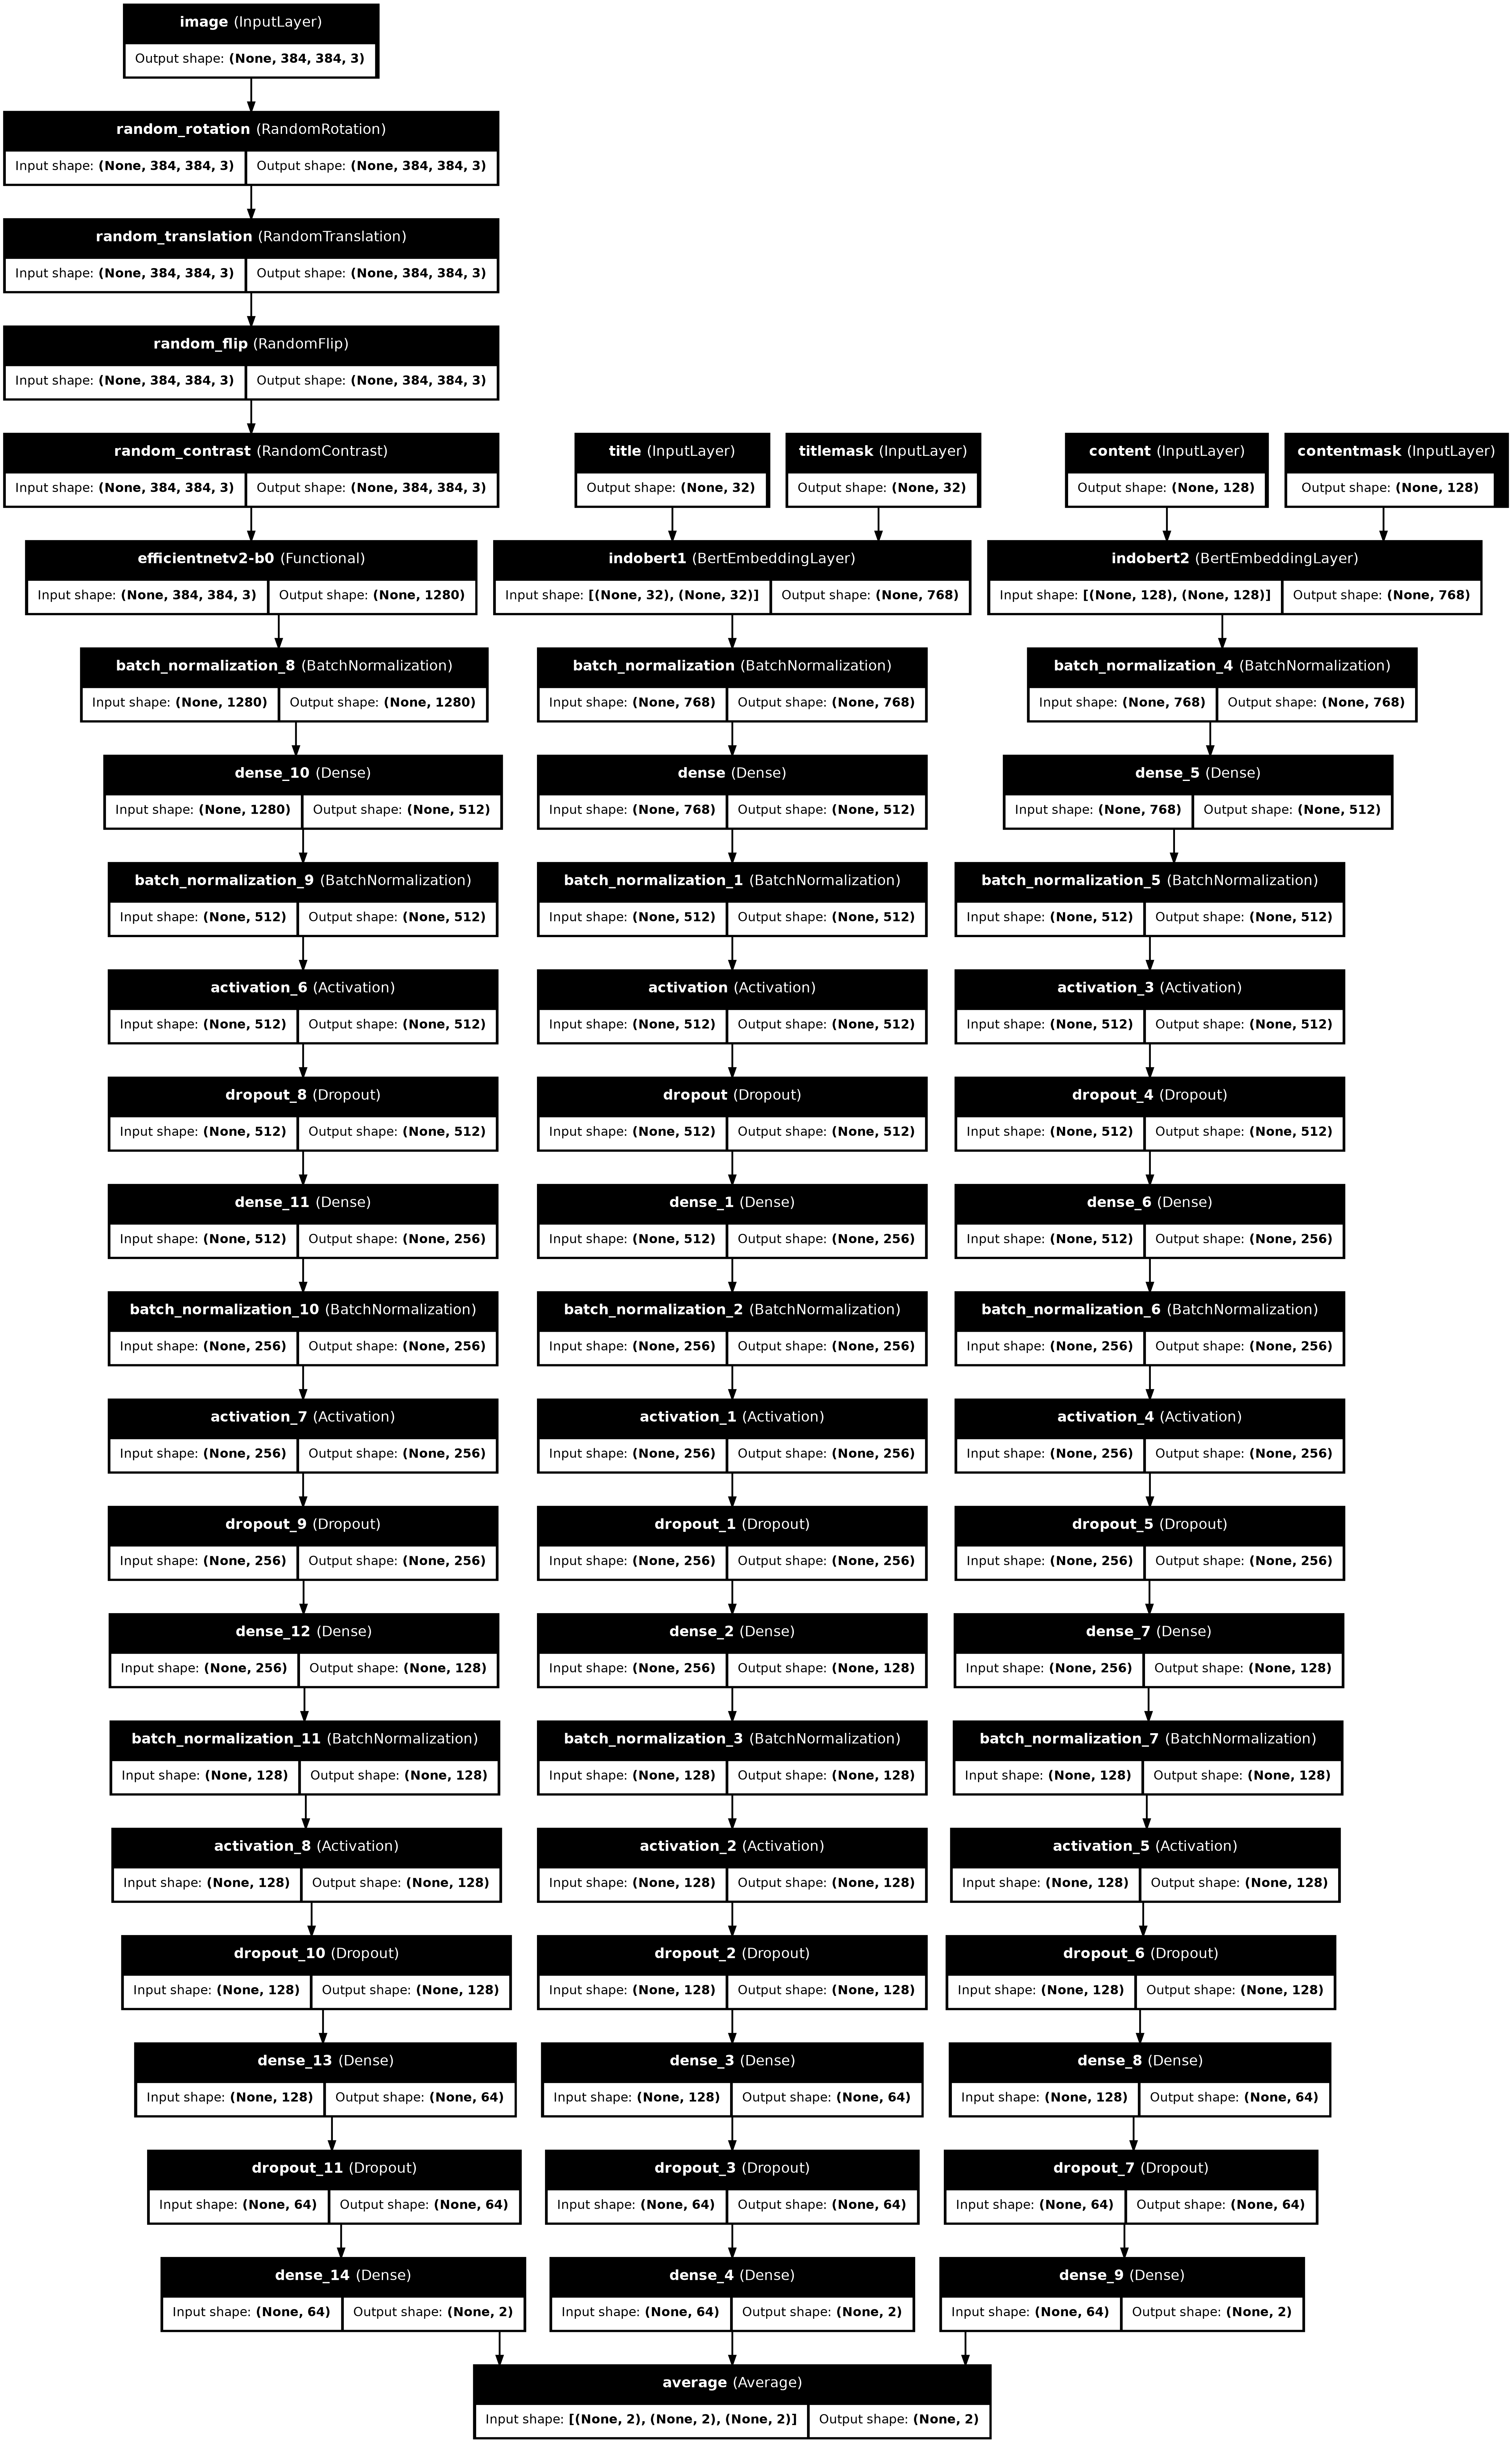

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(
    final,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False
    )

In [7]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
with tf.device("/cpu:0"):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
        )
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/voting_val_loss_{val_loss:.4f}.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=1e-8
    )
    
    history=final.fit(x = dataset,
                      epochs = 50,
                      callbacks=[early_stopping, model_checkpoint, reduce_lr],
                      validation_data=dataVal
                      )

Epoch 1/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 2704s 8s/step - binary_accuracy: 0.6140 - loss: 0.6567 - precision: 0.6140 - recall: 0.6140 - val_binary_accuracy: 0.6861 - val_loss: 0.6150 - val_precision: 0.6861 - val_recall: 0.6861 - learning_rate: 7.0000e-04
Epoch 2/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 2665s 8s/step - binary_accuracy: 0.7110 - loss: 0.5647 - precision: 0.7110 - recall: 0.7110 - val_binary_accuracy: 0.7184 - val_loss: 0.5539 - val_precision: 0.7184 - val_recall: 0.7184 - learning_rate: 7.0000e-04
Epoch 3/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 2779s 8s/step - binary_accuracy: 0.7363 - loss: 0.5331 - precision: 0.7363 - recall: 0.7363 - val_binary_accuracy: 0.7223 - val_loss: 0.5558 - val_precision: 0.7223 - val_recall: 0.7223 - learning_rate: 7.0000e-04
Epoch 4/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 2670s 8s/step - binary_accuracy: 0.7549 - loss: 0.5063 - precision: 0.7549 - recall: 0.7549 - val_binary_accuracy: 0.7302 - val_loss: 0.5406 - val_precision: 0.7302 - val_recall: 0.7302 - learning_r

dict_keys(['binary_accuracy', 'loss', 'precision', 'recall', 'val_binary_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])
Final training loss: 0.42375704646110535


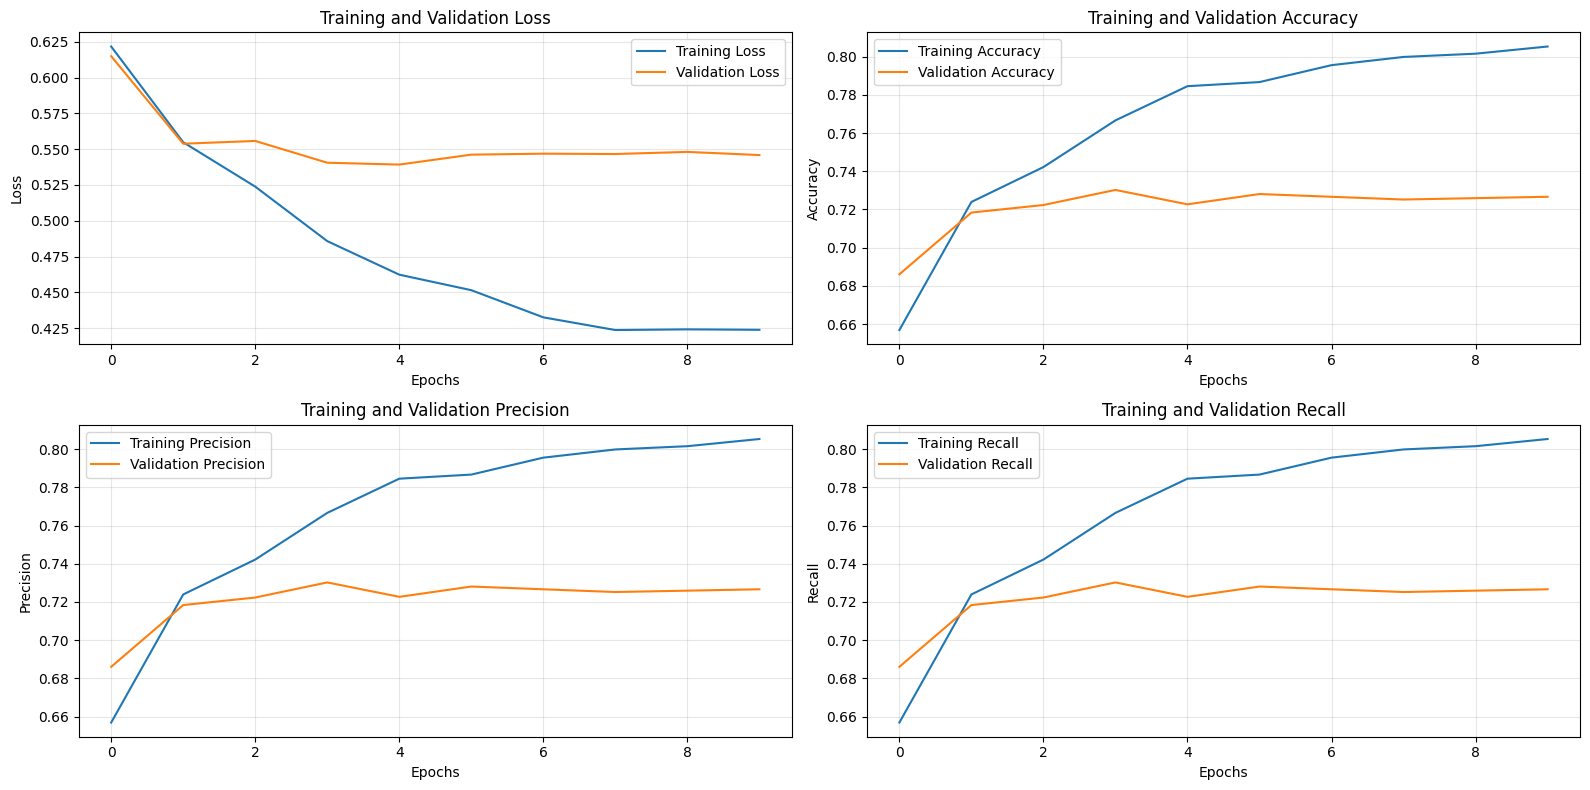


FINAL METRICS SUMMARY
Loss           : Train = 0.4238, Val = 0.5459
Binary_accuracy: Train = 0.8053, Val = 0.7267
Precision      : Train = 0.8053, Val = 0.7267
Recall         : Train = 0.8053, Val = 0.7267


In [8]:
print(history.history.keys())
final_loss = history.history['loss'][-1]
print(f"Final training loss: {final_loss}")

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

if 'binary_accuracy' in history.history:
    plt.subplot(2, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'precision' in history.history:
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)

if 'recall' in history.history:
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL METRICS SUMMARY")
print("="*50)

metrics_to_show = ['loss', 'binary_accuracy', 'precision', 'recall']
for metric in metrics_to_show:
    if metric in history.history:
        train_val = history.history[metric][-1]
        val_key = f'val_{metric}'
        val_val = history.history[val_key][-1] if val_key in history.history else None
        
        print(f"{metric.capitalize():15}: Train = {train_val:.4f}", end="")
        if val_val is not None:
            print(f", Val = {val_val:.4f}")
        else:
            print()